# SLEEP APNEA AND ECG
## DATA FROM PHYSIONET APNEA-ECG DATASET

https://www.researchgate.net/publication/254039441_Detection_of_obstructive_sleep_apnea_through_ECG_signal_features

In [369]:
import wfdb
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import numpy as np
import math
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [364]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [229]:
def NN50_v1(rr_list):
    NN50_v1_count=0
    for i in range(0,len(rr_list)-1):
        if((rr_list[i]-rr_list[i+1])>0.050):
            NN50_v1_count+=1
    return NN50_v1_count

In [230]:
def NN50_v2(rr_list):
    NN50_v2_count=0
    for i in range(1,len(rr_list)):
        if((rr_list[i]-rr_list[i-1])>0.050):
            NN50_v2_count+=1
    return NN50_v2_count

## Leggo i dati di physionet

In [613]:
dfECG=pd.DataFrame()
recordname='C:/Users/sara/Documents/5anno/TESI/DataBase_PhysioNet/www.physionet.org/physiobank/database/apnea-ecg/a01'
# Valori ECG
record = wfdb.rdsamp(recordname)
ecg=record[0]
Fs_ecg=record[1]['fs']
intervallo=len(ecg)/(len(ecg)*Fs_ecg)
time_ecg=[]
for i in range(0,len(ecg)):
    time_ecg.append(intervallo*i)
dfECG['time']=time_ecg
dfECG['ecg']=ecg

In [614]:
# valori label APNEA
dfAPNEA=pd.DataFrame()
ann = wfdb.rdann(recordname, extension="apn")
time_apn=ann.sample/100
apn=ann.symbol
dfAPNEA['time']=time_apn
dfAPNEA['apnea']=apn


In [615]:
# valori QRS
dfQRS=pd.DataFrame()
ann = wfdb.rdann(recordname, extension="qrs")
timeQrs=ann.sample/100
dfQRS['time']=timeQrs


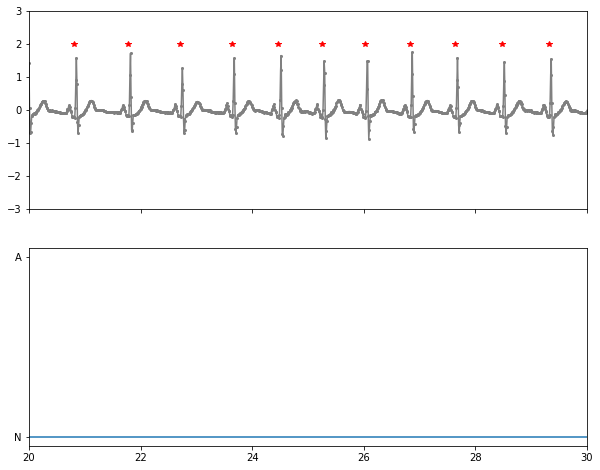

In [616]:
f, axarr = plt.subplots(2, sharex=True,figsize=(10,8))
axarr[0].axis([20,30,-3,3])
axarr[0].plot(time_ecg,ecg, marker='o',markersize=2, color="gray")
#y=[2 for i in range(0,len(dfQRS))]
for i in range(20,50):
    axarr[0].plot(timeQrs[i],2,marker='*',color='red')
axarr[1].step(time_apn,apn)

### Elimino la parte di ECG che non è stata classificata

In [617]:
#if(time_apn[len(time_apn)-1]<(time_ecg[len(time_ecg)-1])):
#    dfECG = dfECG[dfECG['time'] <=time_apn[len(time_apn)-1]]
#ecg=dfECG['ecg']

In [618]:
rr_intervals=[]
time_rr=[]
rr=pd.DataFrame();
for i in range (0,len(dfQRS)):
    if(i==0):
        rr_intervals.append(0)
        time_rr.append(dfQRS['time'][0])
    else:
        rr_intervals.append(timeQrs[i]-timeQrs[i-1])
        time_rr.append(dfQRS['time'][i])
rr['time']=time_rr
rr['intervals']=rr_intervals


#### Lista delle differenze tra rr adiacenti

In [619]:
lista_differenza=[]
lista_diff_squared=[]
lista_diff_media=[]
media=statistics.mean(rr_intervals)
for i in range (0, len(rr_intervals)-1):
        lista_differenza.append(rr_intervals[i]-rr_intervals[i+1])
        lista_diff_squared.append(lista_differenza[i]**2)                                                                                                  

In [620]:
for i in range (0, len(rr_intervals)):
    lista_diff_media.append(abs(rr_intervals[i]-media))

### Divido i dati di ECG in intervalli da 10 secondi

In [621]:
# 10 secondi* Fs campioni al secondo
lunghezza_intervalli=10*Fs_ecg
df_10=pd.DataFrame();
mediaECG=[]
devECG=[]
startTime=[]
stopTime=[]
mediaRR=[]
devRR=[]
startRRIndex=[]
stopRRIndex=[]

numIntervalli=len(ecg)/lunghezza_intervalli
if(len(ecg)%lunghezza_intervalli!=0):
    numIntervalli+=1
print(numIntervalli)
for i in range(0,math.floor(numIntervalli)):
    mediaECG.append((ecg[i*lunghezza_intervalli:i*lunghezza_intervalli+lunghezza_intervalli-1]).mean())
    startTime.append(dfECG['time'][i*lunghezza_intervalli])
    stopTime.append(dfECG['time'][i*lunghezza_intervalli+lunghezza_intervalli-1])
    devECG.append(np.std(ecg[i*lunghezza_intervalli:i*lunghezza_intervalli+lunghezza_intervalli-1]))
df_10['startTime']=startTime  
df_10['stopTime']=stopTime  
df_10['ECG_mean']=mediaECG  
df_10['devECG']=devECG  


2957.0


### Divido gli rr in intervalli da 10 secondi basandomi sugli intervalli di ECG

In [622]:
k=0
start_rr_index=[]
stop_rr_index=[]
NN50_V1_list=[]
NN50_V2_list=[]
pNN50_v1_list=[]
pNN50_v2_list=[]
median=[]
iqr=[]
SDSD=[]
RMSSD=[]
MAD=[]
for i in range (0, len(df_10)):
    if(k<len(rr)):
        start_rr_index.append(k)
        k=k+1
        while( k<len(rr) and df_10['stopTime'][i]>=rr['time'][k] ):
            k=k+1
        stop_rr_index.append(k-1)
       # print(k)

df_10['start_rr_index']=start_rr_index
df_10['stop_rr_index']=stop_rr_index
#print(df_10)
#Estraggo le features basate su rr
for i in range(0,len(df_10)):
    NN50_V1_list.append(NN50_v1(rr_intervals[start_rr_index[i]:stop_rr_index[i]]))
    NN50_V2_list.append(NN50_v2(rr_intervals[start_rr_index[i]:stop_rr_index[i]]))
    if(stop_rr_index[i]-start_rr_index[i]==0):
        pNN50_v1_list.append(1)
        pNN50_v2_list.append(1)
    else:
        pNN50_v1_list.append(NN50_V1_list[i]/(stop_rr_index[i]-start_rr_index[i]))
        pNN50_v2_list.append(NN50_V2_list[i]/(stop_rr_index[i]-start_rr_index[i]))
    median.append(statistics.median(rr_intervals[start_rr_index[i]:stop_rr_index[i]]))
    q75, q25 = np.percentile(rr_intervals[start_rr_index[i]:stop_rr_index[i]], [75 ,25])
    iqr.append(q75 - q25)
    SDSD.append(np.std(lista_differenza[start_rr_index[i]:stop_rr_index[i]]))
    RMSSD.append(math.sqrt((sum(lista_diff_squared[start_rr_index[i]:stop_rr_index[i]]))/(stop_rr_index[i]-start_rr_index[i])))
    MAD.append(statistics.mean(lista_diff_media[start_rr_index[i]:stop_rr_index[i]]))
df_10['NN50_V1']=NN50_V1_list
df_10['NN50_V2']=NN50_V2_list
df_10['pNN50_V1']=pNN50_v1_list
df_10['pNN50_V2']=pNN50_v2_list
df_10['median']=median
df_10['iqr']=iqr
df_10['SDSD']=SDSD
df_10['RMSSD']=RMSSD
df_10['MAD']=MAD


# AGGIUNGO LE LABEL
campioni_al_minuto=60/10
k=0
label=[]
for i in range (0,len(df_10)):
    if((i/campioni_al_minuto)<len(dfAPNEA)):
        if(dfAPNEA['apnea'][math.floor(i/campioni_al_minuto)]=='N'):
            label.append(0)
        else:
            label.append(1)
    else:
        label.append(-1)
df_10['label']=label
df_10[2920:len(df_10)]

,startTime,stopTime,ECG_mean,devECG,start_rr_index,stop_rr_index,NN50_V1,NN50_V2,pNN50_V1,pNN50_V2,median,iqr,SDSD,RMSSD,MAD,label
2920,29200.0,29209.99,-0.001782,0.229733,29527,29535,1,0,0.125000,0.000000,1.110,0.0900,0.028477,0.034095,0.129989,1
2921,29210.0,29219.99,0.004154,0.227031,29536,29544,0,1,0.000000,0.125000,1.055,0.0400,0.061530,0.065096,0.074989,1
2922,29220.0,29229.99,0.000475,0.232668,29545,29553,2,1,0.250000,0.125000,1.145,0.0625,0.050482,0.050621,0.163739,1
2923,29230.0,29239.99,-0.001752,0.267160,29554,29563,3,1,0.333333,0.111111,1.100,0.2900,0.085476,0.091348,0.146943,1
2924,29240.0,29249.99,0.004850,0.279654,29564,29574,1,4,0.100000,0.400000,0.845,0.0825,0.088882,0.093808,0.153009,1
2925,29250.0,29259.99,-0.004164,0.227486,29575,29584,2,0,0.222222,0.000000,1.050,0.0500,0.036515,0.037859,0.061378,1
2926,29260.0,29269.99,0.002718,0.231398,29585,29593,0,1,0.000000,0.125000,0.995,0.0625,0.044282,0.048088,0.028744,1
2927,29270.0,29279.99,-0.001897,0.228121,29594,29602,2,2,0.250000,0.250000,1.110,0.0450,0.064759,0.065192,0.123739,1
2928,29280.0,29289.99,0.000556,0.258175,29603,29612,4,1,0.444444,0.111111,1.110,0.1800,0.070623,0.076303,0.134163,1
2929,29290.0,29299.99,0.003378,0.285588,29613,29625,1,1,0.083333,0.083333,0.760,0.1000,0.045338,0.050990,0.201259,1


In [623]:
df_10[1850:1900]
rr['time'][17577]

16778.75

In [624]:
#Tengo solo i valori che sono stati clasificati come apnea o non
df_10 = df_10[df_10['label'] != -1]

In [625]:
df_10_normalized=pd.DataFrame()
df_10_normalized['ECG_mean']=preprocessing.normalize([np.array(df_10['ECG_mean'])])[0]
df_10_normalized['devECG']=preprocessing.normalize([np.array(df_10['devECG'])])[0]
df_10_normalized['NN50_V1']=preprocessing.normalize([np.array(df_10['NN50_V1'])])[0]
df_10_normalized['NN50_V2']=preprocessing.normalize([np.array(df_10['NN50_V2'])])[0]
df_10_normalized['pNN50_V1']=preprocessing.normalize([np.array(df_10['pNN50_V1'])])[0]
df_10_normalized['pNN50_V2']=preprocessing.normalize([np.array(df_10['pNN50_V2'])])[0]
df_10_normalized['median']=preprocessing.normalize([np.array(df_10['median'])])[0]
df_10_normalized['iqr']=preprocessing.normalize([np.array(df_10['iqr'])])[0]
df_10_normalized['SDSD']=preprocessing.normalize([np.array(df_10['SDSD'])])[0]
df_10_normalized['RMSSD']=preprocessing.normalize([np.array(df_10['RMSSD'])])[0]
df_10_normalized['MAD']=preprocessing.normalize([np.array(df_10['MAD'])])[0]
df_10_normalized['label']=df_10['label']
df_10_normalized

,ECG_mean,devECG,NN50_V1,NN50_V2,pNN50_V1,pNN50_V2,median,iqr,SDSD,RMSSD,MAD,label
0,-0.000106,0.019299,0.008706,0.019883,0.007797,0.017394,0.016145,0.014339,0.064685,0.065997,0.022499,0
1,-0.004055,0.017564,0.008706,0.000000,0.007797,0.000000,0.017969,0.007721,0.006675,0.007434,0.003452,0
2,-0.008067,0.020300,0.008706,0.009942,0.007797,0.008697,0.015233,0.015075,0.012951,0.012492,0.016581,0
3,-0.001690,0.019264,0.017411,0.019883,0.014177,0.015812,0.016054,0.007354,0.011421,0.011251,0.013085,0
4,-0.015417,0.019153,0.017411,0.019883,0.015595,0.017394,0.016054,0.008824,0.011988,0.011592,0.011835,0
5,-0.002661,0.019755,0.000000,0.000000,0.000000,0.000000,0.016419,0.002574,0.006697,0.006459,0.010418,0
6,0.003485,0.020133,0.008706,0.009942,0.007797,0.008697,0.015962,0.007354,0.009946,0.009597,0.013993,0
7,0.007117,0.020426,0.000000,0.000000,0.000000,0.000000,0.015324,0.002941,0.005948,0.005872,0.019081,0
8,-0.005449,0.020122,0.008706,0.019883,0.007088,0.015812,0.015506,0.007354,0.009720,0.009390,0.017736,0
9,-0.001626,0.021062,0.000000,0.019883,0.000000,0.014495,0.015050,0.011766,0.008880,0.008579,0.022909,0


In [626]:
print(df_10_normalized.columns)

Index(['ECG_mean', 'devECG', 'NN50_V1', 'NN50_V2', 'pNN50_V1', 'pNN50_V2',
       'median', 'iqr', 'SDSD', 'RMSSD', 'MAD', 'label'],
      dtype='object')


### Genero train e test set

In [627]:

import random
from numpy.random import permutation

# Randomly shuffle the index of nba.
random_indices = permutation(df_10_normalized.index)
# Set a cutoff for how many items we want in the test set (in this case 1/3 of the items)
test_cutoff = math.floor(len(df_10_normalized)/3)
# Generate the test set by taking the first 1/3 of the randomly shuffled indices.
test = df_10_normalized.loc[random_indices[1:test_cutoff]]
# Generate the train set with YYYYYthe rest of the data.
train = df_10_normalized.loc[random_indices[test_cutoff:]]

In [628]:
x_columns = ['ECG_mean', 'devECG', 'NN50_V1', 'NN50_V2', 'pNN50_V1', 'pNN50_V2',
       'median', 'iqr', 'SDSD', 'RMSSD', 'MAD']
y_column = ['label']

In [641]:
from sklearn.neighbors import KNeighborsRegressor
# Create the knn model.
# Look at the five closest neighbors.
knn = KNeighborsRegressor(n_neighbors=10)
# Fit the model on the training data.
classifier=knn.fit(train[x_columns], train[y_column])
# Make point predictions on the test set using the fit model.
predictions = knn.predict(test[x_columns])

y_pred = classifier.fit(train[x_columns], train[y_column]).predict(test[x_columns])
for i in range(0,len(y_pred)):
    y_pred[i]=math.floor(y_pred[i])

In [642]:
cnf_matrix = confusion_matrix(test[y_column]['label'], y_pred)

Confusion matrix, without normalization
[[ 23  20]
 [198 736]]


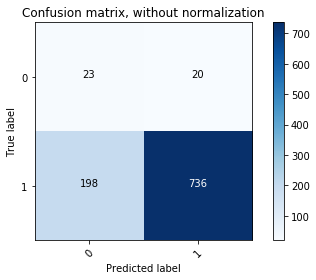

In [643]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0','1'],
                      title='Confusion matrix, without normalization')

Normalized confusion matrix
[[0.53 0.47]
 [0.21 0.79]]


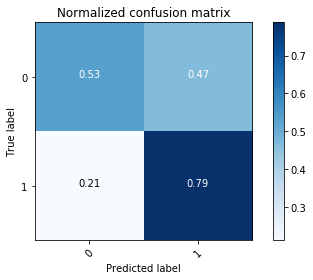

In [644]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0','1'], normalize=True,
                      title='Normalized confusion matrix')